In [1]:
import pandas as pd
import numpy as np
# import geopy
# from geopy import distance
import matplotlib.pyplot as plt

In [2]:

filepath = r'bbb'

# load file
def load(fName): 
    f = filepath + "/" + "{}.txt".format(fName)
    return pd.read_csv(f)

# save file
def save(dfName,fName):
    df = dfName
    df.to_csv(filepath + '/' + "{}".format(fName), sep =',', index=False)
    return print("Saved {} to {}".format(fName,filepath))

# load GTFS files
trips = load('trips')
stops = load('stops')
stop_times = load('stop_times')
shapes = load('shapes')



### Goal:
* Write a pre-processing script that can ingest GTFS and that will "inject" the stop lat and lon to the shapes lat and lon.

### Approach:
* Write logic for a test case using a single trip and route. 
* Will need to match up the shape_id from shapes.txt with shape_id from trips.txt. Will need to get stops from the stop_times.txt and the lat lon
from the stops.txt. 

Loop through the shapes.txt and find where the lat and lon of the stop is in between shape ponts and inject in there? Then will need to reorder
the sequence. -Apply will be better than loop?
* created some 'dummy' cols, so go with using apply

Use the distance from stop to the shape point in order to determine where the stop lat lon should be injected into the shapes.txt.

* Look for the shortest distance for the stop to all of the shape points. Once found, inject the stop coords- replace the orig stop point with the lat lon of stop. 
    - using cdist from scipy- euclidean 
    - using difference of distance between rows to determine what lat lon should be updated
        - it's working okay... got an extra shapepoint in the example
        - the location is a corner where some funky things can happen
* Using np methods because they are fast

In [4]:
# get one trip to test 
onetrip = trips[(trips.trip_id == 784125)]
oneshape = shapes[(shapes.shape_id == 23855)]
stopTimeStops = stop_times['stop_id'][(stop_times.trip_id == 784125)].tolist()
neededStops = stops[stops['stop_id'].isin(stopTimeStops)]
lstlat = neededStops['stop_lat'].tolist()
lstlon = neededStops['stop_lon'].tolist()
result =  zip(lstlat,lstlon)
stopcoordslst = list(result)
len(stopcoordslst)

37

In [8]:
'''MAIN WORK HERE'''
from scipy.spatial.distance import cdist

# turn stops coords to list 
stpCoord = list(stopcoordslst)

# zip these two col together to create shapes lat long 
shplat = oneshape['shape_pt_lat'].tolist()
shplon = oneshape['shape_pt_lon'].tolist()
shpCoord = list(zip(shplat,shplon))



# turn to numpy arrary
shpCoord = np.array(shpCoord)
stpCoord = np.array(stpCoord)


nearest_shapePnt_df = pd.DataFrame({
    'shape_pt_lat' : oneshape.shape_pt_lat,
    'shape_pt_lon' : oneshape.shape_pt_lon,
    'shape_pt_sequence' : oneshape.shape_pt_sequence,
    'dist_to_stp': cdist(shpCoord,stpCoord,'euclidean').min(axis=1) * 10000

})


# find difference between dist_to_stp rows
nearest_shapePnt_df['diff'] = nearest_shapePnt_df['dist_to_stp'] - nearest_shapePnt_df['dist_to_stp'].shift(1)
# create a dummy column marking where the diff is negative
nearest_shapePnt_df['dummy'] = np.where(nearest_shapePnt_df['diff'] < 0,'1','0')
# keep where diff == NaN- this is first shape point and 'should' begin at a stop OR where dist to stop is less than 1.3 OR where dummy == 1 AND the the next value is == 0
# also, keep where dummy value is == 1 AND dist to stop is less than 5 (this may change), this will ensure the closest stop is grabbed based on other criteria
nearest_shapePnt_df['keep'] = np.where(np.logical_or(nearest_shapePnt_df['diff'].isna(),\
                                                     np.logical_or(nearest_shapePnt_df['dist_to_stp'] < 1.3,\
                                                                    np.logical_and(np.logical_and(nearest_shapePnt_df['dummy'] == '1', nearest_shapePnt_df['dist_to_stp'] < 5.),\
                                                                                   np.logical_and(nearest_shapePnt_df['dummy'] == '1', nearest_shapePnt_df['dummy'].shift(-1) == '0')\
                                                                                  )\
                                                                  )\
                                                    ) ,'keep','throw')




# test points query
keepPnts = nearest_shapePnt_df[(nearest_shapePnt_df['keep'] == 'keep')]
keepPnts.info()
# nearest_shapePnt_df.tail(10)
# save(keepPnts,'keepPnts.csv')

# # plot the distance from the stop... the 'valleys' are where the stops are
# plt.figure()
# plt.ylabel("Distance From Stop").set_color("White")
# nearest_shapePnt_df['dist_to_stp'].plot(kind='bar',figsize=(20,7)).axes.get_xaxis().set_visible(False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 2944 to 3312
Data columns (total 7 columns):
shape_pt_lat         38 non-null float64
shape_pt_lon         38 non-null float64
shape_pt_sequence    38 non-null int64
dist_to_stp          38 non-null float64
diff                 37 non-null float64
dummy                38 non-null object
keep                 38 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 2.4+ KB


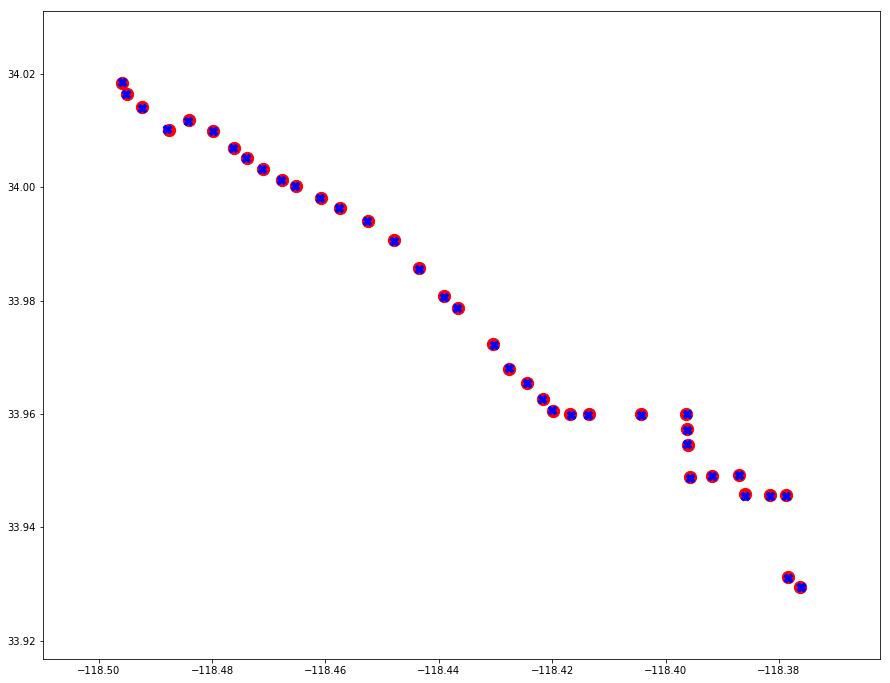

In [7]:
# plot the stops (red) and the shape points the script returns (blue)
import geopandas as gpd

# all of the shape points FOR TESTING
# allShapePoints = gpd.GeoDataFrame(oneshape, geometry=gpd.points_from_xy(oneshape.shape_pt_lon,oneshape.shape_pt_lat))
# stopsTest = testStopdf.plot(figsize=(50,50),color='red',markersize=200)
# # allShapePoints.plot(figsize=(15,15),color='blue')
# allShapePoints.plot(ax=stopsTest, color='blue',marker='X',markersize=50)
# plt.show()



# # testPointsdf = gpd.GeoDataFrame(oneshape, geometry=gpd.points_from_xy(oneshape.shape_pt_lon,oneshape.shape_pt_lat))
testPointsdf = gpd.GeoDataFrame(keepPnts, geometry=gpd.points_from_xy(keepPnts.shape_pt_lon,keepPnts.shape_pt_lat))

testStopdf = gpd.GeoDataFrame(neededStops, geometry=gpd.points_from_xy(neededStops.stop_lon,neededStops.stop_lat))

# plot shape points and stops... see an extra shape point near southern part of route
stopsTest = testStopdf.plot(figsize=(15,15),color='red',markersize=150)
testPointsdf.plot(ax=stopsTest, color='blue',marker='X',markersize=75)
plt.show()
    



In [ ]:
'''
OLDER LOGIC BELOW... still may use some of it.

Use example stop id 1389 'BARRINGTON SB & TEXAS NS'on route 2993 and trip 778854

Use the distance.geodesic function from geopy

Inject the stop coords into the shape.txt 

'''



# def calc_distance(x):
#     stop_coords = [lat,lon for lat,lon in stopcoordslst]
#     shape_coords = (x.shape_pt_lat, x.shape_pt_lon)
#     return geopy.distance.geodesic(stop_coords, shape_coords ).m
# oneshape.apply(calc_distance, axis = 1)


# create df with the shape lat, lon, dist to stop, and pt seq
# out_df_badIndex = pd.DataFrame({
#     'shape_pt_lat' : oneshape.shape_pt_lat,
#     'shape_pt_lon' : oneshape.shape_pt_lon,
#     'shape_pt_sequence' : oneshape.shape_pt_sequence,
#     'dist_to_stp': oneshape.apply(calc_distance, axis = 1) # output of calc_distance function
# })


# # re-index here b/c can't access the original index??
# # is actually kind of nice b/c will be able to use iloc later on to get row, not index
# # also, indexing dosen't matter as the shape_pt_sequence is the main col to keep in order
# out_df = out_df_badIndex.reset_index(drop=True)
# # grab to the index id of the df for the min value in the dist_to_stop column
# row_to_update = out_df['dist_to_stp'].idxmin()
# # grab the index id for the stop before the min value, this is for pt_seq order
# minus_one_row = row_to_update - 1
# # this is the point seq for the new shape point
# new_pt_seq = out_df.iloc[[minus_one_row]]['shape_pt_sequence'].values[0] + 1
# row_to_update


#### Below is a function to insert rows, but with "dummy" columns, probably won't need this.... keeping it in notebook just in case. 

In [ ]:

# # Function (I found and modified) to insert row in the dataframe 'gracefully'
# def Insert_row_(row_number, df, row_value): 
#     df1 = df[0:row_number] 
#     df2 = df[row_number:] 
#     df1.loc[row_number]=row_value 
#     df_result = pd.concat([df1, df2]) 
#     df_result.index = [*range(df_result.shape[0])] 
#     return df_result 

# # row to update
# row_number = row_to_update
# # the pt seq to update
# new_shape_pt_seq = new_pt_seq
# # what will be 'injected'- stop lat lon here
# row_value = [34.047224, -118.459131, 99999, 0] 
  
# if row_number > out_df.index.max()+1: 
#     print("Invalid row_number") 
# else: 
#     # here, create a df and run the insert_row function, b/c that function does not override the existing row, need to drop
#     # the original shape_point. This can be changed later, but if will work for now. Think of it as swapping
#     # out the nearest shape point in the sequence with the lat lon of the stop. 
#     df3 = pd.DataFrame(Insert_row_(row_number, out_df, row_value)).drop_duplicates(subset='shape_pt_sequence',keep='first',inplace=False)
    
    
# df3[(df3['dist_to_stp'] < 200)]

    
# below is the final result, index 97 is now the lat lon of the stop lat lon- not worried about the warning 